In [1]:
import csv
import math
import random
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score, make_scorer, mean_absolute_error, mean_absolute_percentage_error, median_absolute_error
import pickle
from copy import deepcopy

In [2]:
def process_df(df):
  new_df = deepcopy(df)
  new_df.drop(columns=["id", "sale_date", "address", "latitude_rad", "longitude_rad", "latitude", "longitude", "psm"], inplace=True)
  new_df = pd.get_dummies(new_df, columns=["flat_type", "flat_model", "town"], dummy_na = True, dtype=np.uint8)
  new_df.drop(columns=["town_nan", "flat_type_nan", "flat_model_nan"], inplace=True)
  return new_df

In [3]:
def train_test_split_sample(df, startMonth, endMonth):
    sample_df = df[df.sale_month.isin(list(range(startMonth, endMonth)))]
    sample_X, sample_y = sample_df.drop('cpi_psm', axis=1), sample_df.cpi_psm
    return sample_X, sample_y

In [4]:
def train_test_split_year(df, lookback_years):
    latest_month = df.sale_month.max()
    test_months = list(range(latest_month - lookback_years * 12, latest_month + 1))
    train_months = list(range(1, latest_month - lookback_years * 12))

    train = df[df.sale_month.isin(train_months)]
    test = df[df.sale_month.isin(test_months)]
  
    X_train, y_train = train[train.columns.difference(["cpi_psm"])], train["cpi_psm"]
    X_test, y_test = test[test.columns.difference(["cpi_psm"])], test["cpi_psm"]
    
    return X_train, X_test, y_train, y_test

In [5]:
PROCESSED_DATA_PATH = os.path.join("../", "../", "data_processed", "resale_flat_prices")
SEED = 42

In [6]:
df = pd.read_csv(os.path.join(PROCESSED_DATA_PATH, "engineered_data.csv"))
df.head(10)

,id,town,flat_type,flat_model,sale_date,floor,age,relative_tenure,floor_area,psm,...,nearest_post_offices,nearest_bus_stops,nearest_pharmacies,nearest_primary_schools,nearest_parks,nearest_trains,sale_month,cpi,cpi_psm,avg_sora
0,1,JURONG_WEST,3_ROOM,IMPROVED,1990-01-01,5.0,16,0.899953,70.0,334.285714,...,0.798752,0.195397,0.761661,0.541789,0.947906,0.904104,1,61.9,595.125779,NaN
1,2,OTHER,5_ROOM,STANDARD,1990-01-01,5.0,15,0.902280,120.0,916.666667,...,3.042559,0.090376,1.133326,0.159056,0.330270,1.954674,1,61.9,1631.933226,NaN
2,3,BUKIT_MERAH,3_ROOM,IMPROVED,1990-01-01,5.0,15,0.902280,63.0,722.222222,...,1.148847,0.446105,0.850333,0.943485,0.737703,0.932695,1,61.9,1285.765572,NaN
3,4,BUKIT_MERAH,OTHER,IMPROVED,1990-01-01,8.0,21,0.887322,29.0,251.724138,...,1.294327,1.620819,0.431442,0.691163,0.311404,0.448964,1,61.9,448.142165,NaN
4,5,BUKIT_MERAH,OTHER,IMPROVED,1990-01-01,11.0,21,0.887322,29.0,251.724138,...,1.294327,1.620819,0.431442,0.691163,0.311404,0.448964,1,61.9,448.142165,NaN
5,6,BUKIT_MERAH,OTHER,IMPROVED,1990-01-01,8.0,21,0.887322,29.0,310.344828,...,1.294327,1.620819,0.431442,0.691163,0.311404,0.448964,1,61.9,552.504039,NaN
6,7,BUKIT_MERAH,3_ROOM,IMPROVED,1990-01-01,8.0,7,0.918820,64.0,687.500000,...,1.018641,0.485058,0.986821,0.800866,0.808590,0.940111,1,61.9,1223.949919,NaN
7,8,BUKIT_MERAH,3_ROOM,MODEL_A,1990-01-01,8.0,6,0.920652,74.0,1128.378378,...,1.089870,0.544915,0.567711,0.490547,0.708861,0.799126,1,61.9,2008.841636,NaN
8,9,BUKIT_MERAH,3_ROOM,MODEL_A,1990-01-01,5.0,6,0.920652,73.0,1150.684932,...,1.657478,0.053197,0.982875,0.340834,1.013329,0.940071,1,61.9,2048.553788,NaN
9,10,BUKIT_MERAH,3_ROOM,IMPROVED,1990-01-01,2.0,15,0.902280,76.0,671.052632,...,0.690789,0.083148,0.637859,0.507003,0.406147,1.175060,1,61.9,1194.668821,NaN


In [7]:
df["is_imputted_sora"] = np.where(df["avg_sora"].isnull(), True, False)

imp = SimpleImputer()
df["avg_sora"] = imp.fit_transform(df["avg_sora"].to_numpy().reshape(-1, 1))

In [8]:
df.describe()

,id,floor,age,relative_tenure,floor_area,psm,latitude,longitude,latitude_rad,longitude_rad,...,nearest_post_offices,nearest_bus_stops,nearest_pharmacies,nearest_primary_schools,nearest_parks,nearest_trains,sale_month,cpi,cpi_psm,avg_sora
count,865827.000000,865827.000000,865827.000000,865827.000000,865827.000000,865827.000000,865827.000000,865827.000000,865827.000000,865827.000000,...,865827.000000,865827.000000,865827.000000,865827.000000,865827.000000,865827.000000,865827.000000,865827.000000,865827.000000,865827.000000
mean,432914.000000,7.626058,17.349350,0.892896,96.135123,3173.083607,1.497366,103.148474,0.026134,1.800280,...,62.788172,61.708270,62.231490,61.990540,62.338973,62.217020,190.483063,82.131055,4131.625468,0.763427
std,249942.870098,4.738340,10.217708,0.029046,25.796313,1385.776553,2.612377,11.573640,0.045595,0.201998,...,923.588875,923.284911,923.497181,923.502716,923.385468,923.496916,104.298678,11.879488,1363.166128,0.659903
min,1.000000,2.000000,0.000000,0.731586,28.000000,161.290323,-37.840251,-122.683299,-0.660437,-2.141228,...,0.007724,0.000003,0.000790,0.042886,0.021691,0.018401,1.000000,61.900000,284.387097,0.035633
25%,216457.500000,5.000000,9.000000,0.878870,73.000000,2266.666667,1.335322,103.772049,0.023306,1.811164,...,0.754831,0.076599,0.395358,0.241143,0.477918,0.375599,107.000000,73.400000,3321.083800,0.260618
50%,432914.000000,8.000000,16.000000,0.899953,93.000000,2870.370370,1.355961,103.843296,0.023666,1.812407,...,1.136412,0.112533,0.610644,0.370503,0.705703,0.585058,175.000000,76.500000,4031.953168,0.763427
75%,649370.500000,11.000000,24.000000,0.915007,114.000000,3990.180006,1.383056,103.897860,0.024139,1.813360,...,1.559133,0.156376,0.869802,0.540301,0.994037,0.853369,269.000000,95.900000,4868.754343,0.763427
max,865827.000000,50.000000,55.000000,0.930702,307.000000,13310.344828,50.820779,145.019498,0.886990,2.531068,...,16929.865540,16924.138572,16928.066230,16927.190593,16926.344996,16927.966733,393.000000,110.200000,14163.126574,3.414986


In [9]:
new_df = process_df(df)
sample_X, sample_y = train_test_split_sample(new_df, 200, 236)

# GridSearchCV

In [10]:
parameters = {'min_samples_split':[2,5,10,15,20,25,30,35], 'max_depth':range(15, 45, 5), 'min_samples_leaf':[1,2,4,6,8,10,12,14,16]}
grid = GridSearchCV(DecisionTreeRegressor(random_state=SEED, criterion='squared_error'), parameters, scoring='neg_root_mean_squared_error', verbose = 4, return_train_score = True)
grid.fit(X=sample_X, y=sample_y)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
[CV 1/5] END max_depth=15, min_samples_leaf=1, min_samples_split=2;, score=(train=-328.424, test=-371.929) total time=   1.1s
[CV 2/5] END max_depth=15, min_samples_leaf=1, min_samples_split=2;, score=(train=-322.961, test=-456.672) total time=   1.3s
[CV 3/5] END max_depth=15, min_samples_leaf=1, min_samples_split=2;, score=(train=-304.569, test=-528.555) total time=   1.4s
[CV 4/5] END max_depth=15, min_samples_leaf=1, min_samples_split=2;, score=(train=-307.310, test=-442.381) total time=   1.2s
[CV 5/5] END max_depth=15, min_samples_leaf=1, min_samples_split=2;, score=(train=-336.369, test=-464.594) total time=   1.2s
[CV 1/5] END max_depth=15, min_samples_leaf=1, min_samples_split=5;, score=(train=-331.134, test=-376.352) total time=   1.4s
[CV 2/5] END max_depth=15, min_samples_leaf=1, min_samples_split=5;, score=(train=-325.473, test=-449.483) total time=   1.1s
[CV 3/5] END max_depth=15, min_samples_leaf=1, min_sam

[CV 1/5] END max_depth=15, min_samples_leaf=2, min_samples_split=25;, score=(train=-348.149, test=-373.201) total time=   0.7s
[CV 2/5] END max_depth=15, min_samples_leaf=2, min_samples_split=25;, score=(train=-342.826, test=-438.440) total time=   0.8s
[CV 3/5] END max_depth=15, min_samples_leaf=2, min_samples_split=25;, score=(train=-323.737, test=-517.996) total time=   1.0s
[CV 4/5] END max_depth=15, min_samples_leaf=2, min_samples_split=25;, score=(train=-330.626, test=-426.457) total time=   1.2s
[CV 5/5] END max_depth=15, min_samples_leaf=2, min_samples_split=25;, score=(train=-357.081, test=-473.275) total time=   1.1s
[CV 1/5] END max_depth=15, min_samples_leaf=2, min_samples_split=30;, score=(train=-351.331, test=-372.191) total time=   1.2s
[CV 2/5] END max_depth=15, min_samples_leaf=2, min_samples_split=30;, score=(train=-346.428, test=-436.955) total time=   1.2s
[CV 3/5] END max_depth=15, min_samples_leaf=2, min_samples_split=30;, score=(train=-327.394, test=-518.823) tot

[CV 1/5] END max_depth=15, min_samples_leaf=6, min_samples_split=10;, score=(train=-344.307, test=-377.443) total time=   0.7s
[CV 2/5] END max_depth=15, min_samples_leaf=6, min_samples_split=10;, score=(train=-338.873, test=-441.205) total time=   0.8s
[CV 3/5] END max_depth=15, min_samples_leaf=6, min_samples_split=10;, score=(train=-320.340, test=-522.181) total time=   0.8s
[CV 4/5] END max_depth=15, min_samples_leaf=6, min_samples_split=10;, score=(train=-326.343, test=-444.445) total time=   1.7s
[CV 5/5] END max_depth=15, min_samples_leaf=6, min_samples_split=10;, score=(train=-352.396, test=-467.280) total time=   1.1s
[CV 1/5] END max_depth=15, min_samples_leaf=6, min_samples_split=15;, score=(train=-346.139, test=-390.900) total time=   0.9s
[CV 2/5] END max_depth=15, min_samples_leaf=6, min_samples_split=15;, score=(train=-340.427, test=-435.192) total time=   0.9s
[CV 3/5] END max_depth=15, min_samples_leaf=6, min_samples_split=15;, score=(train=-322.115, test=-522.392) tot

[CV 1/5] END max_depth=15, min_samples_leaf=8, min_samples_split=35;, score=(train=-359.786, test=-395.410) total time=   1.0s
[CV 2/5] END max_depth=15, min_samples_leaf=8, min_samples_split=35;, score=(train=-354.125, test=-440.561) total time=   1.0s
[CV 3/5] END max_depth=15, min_samples_leaf=8, min_samples_split=35;, score=(train=-336.039, test=-524.226) total time=   1.0s
[CV 4/5] END max_depth=15, min_samples_leaf=8, min_samples_split=35;, score=(train=-343.217, test=-437.792) total time=   1.0s
[CV 5/5] END max_depth=15, min_samples_leaf=8, min_samples_split=35;, score=(train=-369.159, test=-465.734) total time=   1.0s
[CV 1/5] END max_depth=15, min_samples_leaf=10, min_samples_split=2;, score=(train=-353.196, test=-393.475) total time=   1.0s
[CV 2/5] END max_depth=15, min_samples_leaf=10, min_samples_split=2;, score=(train=-347.374, test=-435.444) total time=   1.0s
[CV 3/5] END max_depth=15, min_samples_leaf=10, min_samples_split=2;, score=(train=-328.909, test=-521.310) tot

[CV 1/5] END max_depth=15, min_samples_leaf=12, min_samples_split=20;, score=(train=-356.707, test=-395.501) total time=   1.3s
[CV 2/5] END max_depth=15, min_samples_leaf=12, min_samples_split=20;, score=(train=-350.719, test=-443.843) total time=   1.2s
[CV 3/5] END max_depth=15, min_samples_leaf=12, min_samples_split=20;, score=(train=-332.791, test=-522.925) total time=   1.3s
[CV 4/5] END max_depth=15, min_samples_leaf=12, min_samples_split=20;, score=(train=-340.852, test=-447.018) total time=   1.0s
[CV 5/5] END max_depth=15, min_samples_leaf=12, min_samples_split=20;, score=(train=-366.944, test=-471.336) total time=   1.0s
[CV 1/5] END max_depth=15, min_samples_leaf=12, min_samples_split=25;, score=(train=-357.343, test=-395.649) total time=   0.9s
[CV 2/5] END max_depth=15, min_samples_leaf=12, min_samples_split=25;, score=(train=-350.907, test=-437.510) total time=   0.9s
[CV 3/5] END max_depth=15, min_samples_leaf=12, min_samples_split=25;, score=(train=-332.932, test=-522.

[CV 1/5] END max_depth=15, min_samples_leaf=16, min_samples_split=5;, score=(train=-364.211, test=-402.129) total time=   0.8s
[CV 2/5] END max_depth=15, min_samples_leaf=16, min_samples_split=5;, score=(train=-357.886, test=-452.498) total time=   1.3s
[CV 3/5] END max_depth=15, min_samples_leaf=16, min_samples_split=5;, score=(train=-340.369, test=-527.506) total time=   0.9s
[CV 4/5] END max_depth=15, min_samples_leaf=16, min_samples_split=5;, score=(train=-345.787, test=-436.429) total time=   0.7s
[CV 5/5] END max_depth=15, min_samples_leaf=16, min_samples_split=5;, score=(train=-374.201, test=-474.555) total time=   0.8s
[CV 1/5] END max_depth=15, min_samples_leaf=16, min_samples_split=10;, score=(train=-364.211, test=-402.129) total time=   0.7s
[CV 2/5] END max_depth=15, min_samples_leaf=16, min_samples_split=10;, score=(train=-357.886, test=-452.498) total time=   0.7s
[CV 3/5] END max_depth=15, min_samples_leaf=16, min_samples_split=10;, score=(train=-340.369, test=-527.506) 

[CV 1/5] END max_depth=20, min_samples_leaf=1, min_samples_split=30;, score=(train=-279.412, test=-351.806) total time=   0.9s
[CV 2/5] END max_depth=20, min_samples_leaf=1, min_samples_split=30;, score=(train=-272.166, test=-438.277) total time=   1.0s
[CV 3/5] END max_depth=20, min_samples_leaf=1, min_samples_split=30;, score=(train=-263.642, test=-477.695) total time=   1.0s
[CV 4/5] END max_depth=20, min_samples_leaf=1, min_samples_split=30;, score=(train=-266.970, test=-394.703) total time=   0.9s
[CV 5/5] END max_depth=20, min_samples_leaf=1, min_samples_split=30;, score=(train=-288.007, test=-423.168) total time=   0.9s
[CV 1/5] END max_depth=20, min_samples_leaf=1, min_samples_split=35;, score=(train=-287.207, test=-356.663) total time=   0.9s
[CV 2/5] END max_depth=20, min_samples_leaf=1, min_samples_split=35;, score=(train=-278.214, test=-419.286) total time=   0.9s
[CV 3/5] END max_depth=20, min_samples_leaf=1, min_samples_split=35;, score=(train=-270.994, test=-478.472) tot

[CV 1/5] END max_depth=20, min_samples_leaf=4, min_samples_split=15;, score=(train=-264.082, test=-347.100) total time=   1.9s
[CV 2/5] END max_depth=20, min_samples_leaf=4, min_samples_split=15;, score=(train=-255.466, test=-438.634) total time=   1.0s
[CV 3/5] END max_depth=20, min_samples_leaf=4, min_samples_split=15;, score=(train=-250.318, test=-475.016) total time=   1.0s
[CV 4/5] END max_depth=20, min_samples_leaf=4, min_samples_split=15;, score=(train=-250.373, test=-407.555) total time=   0.9s
[CV 5/5] END max_depth=20, min_samples_leaf=4, min_samples_split=15;, score=(train=-272.060, test=-422.301) total time=   1.0s
[CV 1/5] END max_depth=20, min_samples_leaf=4, min_samples_split=20;, score=(train=-272.890, test=-350.175) total time=   1.0s
[CV 2/5] END max_depth=20, min_samples_leaf=4, min_samples_split=20;, score=(train=-263.583, test=-432.758) total time=   0.9s
[CV 3/5] END max_depth=20, min_samples_leaf=4, min_samples_split=20;, score=(train=-256.781, test=-474.657) tot

[CV 1/5] END max_depth=20, min_samples_leaf=8, min_samples_split=2;, score=(train=-276.676, test=-366.190) total time=   1.0s
[CV 2/5] END max_depth=20, min_samples_leaf=8, min_samples_split=2;, score=(train=-268.111, test=-424.108) total time=   1.0s
[CV 3/5] END max_depth=20, min_samples_leaf=8, min_samples_split=2;, score=(train=-260.730, test=-478.120) total time=   1.0s
[CV 4/5] END max_depth=20, min_samples_leaf=8, min_samples_split=2;, score=(train=-261.772, test=-411.474) total time=   1.0s
[CV 5/5] END max_depth=20, min_samples_leaf=8, min_samples_split=2;, score=(train=-284.184, test=-417.614) total time=   1.0s
[CV 1/5] END max_depth=20, min_samples_leaf=8, min_samples_split=5;, score=(train=-276.676, test=-366.190) total time=   1.0s
[CV 2/5] END max_depth=20, min_samples_leaf=8, min_samples_split=5;, score=(train=-268.111, test=-424.108) total time=   1.0s
[CV 3/5] END max_depth=20, min_samples_leaf=8, min_samples_split=5;, score=(train=-260.730, test=-478.120) total time=

[CV 1/5] END max_depth=20, min_samples_leaf=10, min_samples_split=25;, score=(train=-290.184, test=-371.776) total time=   1.0s
[CV 2/5] END max_depth=20, min_samples_leaf=10, min_samples_split=25;, score=(train=-280.487, test=-422.815) total time=   1.0s
[CV 3/5] END max_depth=20, min_samples_leaf=10, min_samples_split=25;, score=(train=-270.864, test=-478.508) total time=   1.2s
[CV 4/5] END max_depth=20, min_samples_leaf=10, min_samples_split=25;, score=(train=-276.659, test=-402.292) total time=   1.0s
[CV 5/5] END max_depth=20, min_samples_leaf=10, min_samples_split=25;, score=(train=-296.710, test=-418.396) total time=   1.0s
[CV 1/5] END max_depth=20, min_samples_leaf=10, min_samples_split=30;, score=(train=-294.674, test=-375.705) total time=   0.9s
[CV 2/5] END max_depth=20, min_samples_leaf=10, min_samples_split=30;, score=(train=-286.120, test=-428.979) total time=   1.0s
[CV 3/5] END max_depth=20, min_samples_leaf=10, min_samples_split=30;, score=(train=-275.367, test=-480.

[CV 1/5] END max_depth=20, min_samples_leaf=14, min_samples_split=10;, score=(train=-299.541, test=-385.289) total time=   1.0s
[CV 2/5] END max_depth=20, min_samples_leaf=14, min_samples_split=10;, score=(train=-289.802, test=-433.162) total time=   1.1s
[CV 3/5] END max_depth=20, min_samples_leaf=14, min_samples_split=10;, score=(train=-279.466, test=-483.208) total time=   1.1s
[CV 4/5] END max_depth=20, min_samples_leaf=14, min_samples_split=10;, score=(train=-287.654, test=-396.562) total time=   0.9s
[CV 5/5] END max_depth=20, min_samples_leaf=14, min_samples_split=10;, score=(train=-307.358, test=-437.152) total time=   0.9s
[CV 1/5] END max_depth=20, min_samples_leaf=14, min_samples_split=15;, score=(train=-299.541, test=-385.289) total time=   0.9s
[CV 2/5] END max_depth=20, min_samples_leaf=14, min_samples_split=15;, score=(train=-289.802, test=-433.162) total time=   1.1s
[CV 3/5] END max_depth=20, min_samples_leaf=14, min_samples_split=15;, score=(train=-279.466, test=-483.

[CV 1/5] END max_depth=20, min_samples_leaf=16, min_samples_split=35;, score=(train=-308.021, test=-382.434) total time=   0.9s
[CV 2/5] END max_depth=20, min_samples_leaf=16, min_samples_split=35;, score=(train=-298.702, test=-445.284) total time=   1.0s
[CV 3/5] END max_depth=20, min_samples_leaf=16, min_samples_split=35;, score=(train=-287.549, test=-483.329) total time=   0.9s
[CV 4/5] END max_depth=20, min_samples_leaf=16, min_samples_split=35;, score=(train=-294.472, test=-417.007) total time=   0.8s
[CV 5/5] END max_depth=20, min_samples_leaf=16, min_samples_split=35;, score=(train=-314.069, test=-433.114) total time=   0.9s
[CV 1/5] END max_depth=25, min_samples_leaf=1, min_samples_split=2;, score=(train=-133.488, test=-373.696) total time=   1.2s
[CV 2/5] END max_depth=25, min_samples_leaf=1, min_samples_split=2;, score=(train=-125.264, test=-455.936) total time=   2.0s
[CV 3/5] END max_depth=25, min_samples_leaf=1, min_samples_split=2;, score=(train=-129.966, test=-478.838) t

[CV 1/5] END max_depth=25, min_samples_leaf=2, min_samples_split=20;, score=(train=-227.027, test=-351.859) total time=   1.8s
[CV 2/5] END max_depth=25, min_samples_leaf=2, min_samples_split=20;, score=(train=-218.895, test=-416.104) total time=   2.3s
[CV 3/5] END max_depth=25, min_samples_leaf=2, min_samples_split=20;, score=(train=-208.873, test=-450.663) total time=   1.6s
[CV 4/5] END max_depth=25, min_samples_leaf=2, min_samples_split=20;, score=(train=-218.618, test=-390.886) total time=   1.3s
[CV 5/5] END max_depth=25, min_samples_leaf=2, min_samples_split=20;, score=(train=-230.067, test=-409.015) total time=   1.2s
[CV 1/5] END max_depth=25, min_samples_leaf=2, min_samples_split=25;, score=(train=-238.034, test=-354.730) total time=   1.2s
[CV 2/5] END max_depth=25, min_samples_leaf=2, min_samples_split=25;, score=(train=-230.171, test=-428.873) total time=   1.1s
[CV 3/5] END max_depth=25, min_samples_leaf=2, min_samples_split=25;, score=(train=-219.311, test=-450.581) tot

[CV 1/5] END max_depth=25, min_samples_leaf=6, min_samples_split=5;, score=(train=-223.548, test=-352.711) total time=   1.0s
[CV 2/5] END max_depth=25, min_samples_leaf=6, min_samples_split=5;, score=(train=-214.645, test=-437.619) total time=   1.0s
[CV 3/5] END max_depth=25, min_samples_leaf=6, min_samples_split=5;, score=(train=-205.984, test=-457.395) total time=   1.0s
[CV 4/5] END max_depth=25, min_samples_leaf=6, min_samples_split=5;, score=(train=-214.751, test=-398.743) total time=   1.0s
[CV 5/5] END max_depth=25, min_samples_leaf=6, min_samples_split=5;, score=(train=-224.515, test=-395.164) total time=   1.0s
[CV 1/5] END max_depth=25, min_samples_leaf=6, min_samples_split=10;, score=(train=-223.548, test=-352.711) total time=   1.0s
[CV 2/5] END max_depth=25, min_samples_leaf=6, min_samples_split=10;, score=(train=-214.645, test=-437.619) total time=   1.0s
[CV 3/5] END max_depth=25, min_samples_leaf=6, min_samples_split=10;, score=(train=-205.984, test=-457.395) total ti

[CV 1/5] END max_depth=25, min_samples_leaf=8, min_samples_split=30;, score=(train=-264.242, test=-371.164) total time=   1.2s
[CV 2/5] END max_depth=25, min_samples_leaf=8, min_samples_split=30;, score=(train=-255.259, test=-418.575) total time=   0.9s
[CV 3/5] END max_depth=25, min_samples_leaf=8, min_samples_split=30;, score=(train=-241.644, test=-462.334) total time=   1.2s
[CV 4/5] END max_depth=25, min_samples_leaf=8, min_samples_split=30;, score=(train=-255.482, test=-402.703) total time=   1.0s
[CV 5/5] END max_depth=25, min_samples_leaf=8, min_samples_split=30;, score=(train=-264.742, test=-402.915) total time=   1.1s
[CV 1/5] END max_depth=25, min_samples_leaf=8, min_samples_split=35;, score=(train=-272.407, test=-366.640) total time=   0.9s
[CV 2/5] END max_depth=25, min_samples_leaf=8, min_samples_split=35;, score=(train=-263.211, test=-416.140) total time=   1.3s
[CV 3/5] END max_depth=25, min_samples_leaf=8, min_samples_split=35;, score=(train=-249.811, test=-463.059) tot

[CV 1/5] END max_depth=25, min_samples_leaf=12, min_samples_split=15;, score=(train=-265.633, test=-371.395) total time=   1.5s
[CV 2/5] END max_depth=25, min_samples_leaf=12, min_samples_split=15;, score=(train=-255.998, test=-425.522) total time=   1.5s
[CV 3/5] END max_depth=25, min_samples_leaf=12, min_samples_split=15;, score=(train=-242.476, test=-461.673) total time=   1.2s
[CV 4/5] END max_depth=25, min_samples_leaf=12, min_samples_split=15;, score=(train=-258.644, test=-406.252) total time=   1.6s
[CV 5/5] END max_depth=25, min_samples_leaf=12, min_samples_split=15;, score=(train=-266.576, test=-403.956) total time=   1.5s
[CV 1/5] END max_depth=25, min_samples_leaf=12, min_samples_split=20;, score=(train=-265.633, test=-371.395) total time=   1.5s
[CV 2/5] END max_depth=25, min_samples_leaf=12, min_samples_split=20;, score=(train=-255.998, test=-425.522) total time=   1.1s
[CV 3/5] END max_depth=25, min_samples_leaf=12, min_samples_split=20;, score=(train=-242.476, test=-461.

[CV 1/5] END max_depth=25, min_samples_leaf=16, min_samples_split=2;, score=(train=-283.781, test=-379.923) total time=   1.2s
[CV 2/5] END max_depth=25, min_samples_leaf=16, min_samples_split=2;, score=(train=-275.405, test=-431.985) total time=   1.1s
[CV 3/5] END max_depth=25, min_samples_leaf=16, min_samples_split=2;, score=(train=-259.631, test=-468.347) total time=   1.1s
[CV 4/5] END max_depth=25, min_samples_leaf=16, min_samples_split=2;, score=(train=-275.305, test=-413.376) total time=   1.1s
[CV 5/5] END max_depth=25, min_samples_leaf=16, min_samples_split=2;, score=(train=-283.933, test=-413.172) total time=   1.2s
[CV 1/5] END max_depth=25, min_samples_leaf=16, min_samples_split=5;, score=(train=-283.781, test=-379.923) total time=   1.2s
[CV 2/5] END max_depth=25, min_samples_leaf=16, min_samples_split=5;, score=(train=-275.405, test=-431.985) total time=   1.1s
[CV 3/5] END max_depth=25, min_samples_leaf=16, min_samples_split=5;, score=(train=-259.631, test=-468.347) tot

[CV 1/5] END max_depth=30, min_samples_leaf=1, min_samples_split=25;, score=(train=-223.799, test=-358.062) total time=   1.2s
[CV 2/5] END max_depth=30, min_samples_leaf=1, min_samples_split=25;, score=(train=-217.110, test=-419.980) total time=   1.3s
[CV 3/5] END max_depth=30, min_samples_leaf=1, min_samples_split=25;, score=(train=-202.902, test=-453.726) total time=   1.6s
[CV 4/5] END max_depth=30, min_samples_leaf=1, min_samples_split=25;, score=(train=-216.303, test=-395.168) total time=   1.4s
[CV 5/5] END max_depth=30, min_samples_leaf=1, min_samples_split=25;, score=(train=-221.507, test=-403.333) total time=   1.1s
[CV 1/5] END max_depth=30, min_samples_leaf=1, min_samples_split=30;, score=(train=-235.687, test=-356.107) total time=   0.9s
[CV 2/5] END max_depth=30, min_samples_leaf=1, min_samples_split=30;, score=(train=-229.400, test=-410.073) total time=   1.0s
[CV 3/5] END max_depth=30, min_samples_leaf=1, min_samples_split=30;, score=(train=-215.685, test=-454.453) tot

[CV 1/5] END max_depth=30, min_samples_leaf=4, min_samples_split=10;, score=(train=-188.291, test=-354.102) total time=   1.1s
[CV 2/5] END max_depth=30, min_samples_leaf=4, min_samples_split=10;, score=(train=-180.205, test=-432.770) total time=   1.4s
[CV 3/5] END max_depth=30, min_samples_leaf=4, min_samples_split=10;, score=(train=-170.443, test=-457.522) total time=   1.2s
[CV 4/5] END max_depth=30, min_samples_leaf=4, min_samples_split=10;, score=(train=-181.187, test=-396.355) total time=   1.5s
[CV 5/5] END max_depth=30, min_samples_leaf=4, min_samples_split=10;, score=(train=-184.435, test=-403.404) total time=   1.0s
[CV 1/5] END max_depth=30, min_samples_leaf=4, min_samples_split=15;, score=(train=-208.176, test=-347.653) total time=   1.2s
[CV 2/5] END max_depth=30, min_samples_leaf=4, min_samples_split=15;, score=(train=-199.845, test=-420.960) total time=   1.4s
[CV 3/5] END max_depth=30, min_samples_leaf=4, min_samples_split=15;, score=(train=-188.906, test=-453.325) tot

[CV 1/5] END max_depth=30, min_samples_leaf=6, min_samples_split=35;, score=(train=-261.857, test=-366.327) total time=   1.1s
[CV 2/5] END max_depth=30, min_samples_leaf=6, min_samples_split=35;, score=(train=-253.875, test=-411.123) total time=   1.0s
[CV 3/5] END max_depth=30, min_samples_leaf=6, min_samples_split=35;, score=(train=-238.430, test=-456.055) total time=   1.9s
[CV 4/5] END max_depth=30, min_samples_leaf=6, min_samples_split=35;, score=(train=-254.680, test=-404.560) total time=   1.1s
[CV 5/5] END max_depth=30, min_samples_leaf=6, min_samples_split=35;, score=(train=-258.888, test=-403.876) total time=   1.1s
[CV 1/5] END max_depth=30, min_samples_leaf=8, min_samples_split=2;, score=(train=-232.010, test=-362.323) total time=   1.0s
[CV 2/5] END max_depth=30, min_samples_leaf=8, min_samples_split=2;, score=(train=-224.480, test=-421.960) total time=   1.4s
[CV 3/5] END max_depth=30, min_samples_leaf=8, min_samples_split=2;, score=(train=-210.290, test=-456.751) total 

[CV 1/5] END max_depth=30, min_samples_leaf=10, min_samples_split=20;, score=(train=-248.178, test=-370.318) total time=   1.5s
[CV 2/5] END max_depth=30, min_samples_leaf=10, min_samples_split=20;, score=(train=-239.128, test=-429.378) total time=   1.8s
[CV 3/5] END max_depth=30, min_samples_leaf=10, min_samples_split=20;, score=(train=-224.161, test=-457.236) total time=   1.2s
[CV 4/5] END max_depth=30, min_samples_leaf=10, min_samples_split=20;, score=(train=-241.844, test=-398.818) total time=   1.1s
[CV 5/5] END max_depth=30, min_samples_leaf=10, min_samples_split=20;, score=(train=-246.563, test=-407.251) total time=   1.6s
[CV 1/5] END max_depth=30, min_samples_leaf=10, min_samples_split=25;, score=(train=-256.122, test=-371.000) total time=   1.7s
[CV 2/5] END max_depth=30, min_samples_leaf=10, min_samples_split=25;, score=(train=-246.585, test=-416.818) total time=   1.4s
[CV 3/5] END max_depth=30, min_samples_leaf=10, min_samples_split=25;, score=(train=-230.614, test=-458.

[CV 1/5] END max_depth=30, min_samples_leaf=14, min_samples_split=5;, score=(train=-271.341, test=-384.283) total time=   1.0s
[CV 2/5] END max_depth=30, min_samples_leaf=14, min_samples_split=5;, score=(train=-261.909, test=-414.285) total time=   1.0s
[CV 3/5] END max_depth=30, min_samples_leaf=14, min_samples_split=5;, score=(train=-245.175, test=-464.763) total time=   1.9s
[CV 4/5] END max_depth=30, min_samples_leaf=14, min_samples_split=5;, score=(train=-265.586, test=-403.550) total time=   0.9s
[CV 5/5] END max_depth=30, min_samples_leaf=14, min_samples_split=5;, score=(train=-271.279, test=-407.076) total time=   1.0s
[CV 1/5] END max_depth=30, min_samples_leaf=14, min_samples_split=10;, score=(train=-271.341, test=-384.283) total time=   1.8s
[CV 2/5] END max_depth=30, min_samples_leaf=14, min_samples_split=10;, score=(train=-261.909, test=-414.285) total time=   1.0s
[CV 3/5] END max_depth=30, min_samples_leaf=14, min_samples_split=10;, score=(train=-245.175, test=-464.763) 

[CV 1/5] END max_depth=30, min_samples_leaf=16, min_samples_split=30;, score=(train=-280.532, test=-379.598) total time=   1.8s
[CV 2/5] END max_depth=30, min_samples_leaf=16, min_samples_split=30;, score=(train=-272.519, test=-421.643) total time=   0.9s
[CV 3/5] END max_depth=30, min_samples_leaf=16, min_samples_split=30;, score=(train=-255.061, test=-465.889) total time=   1.0s
[CV 4/5] END max_depth=30, min_samples_leaf=16, min_samples_split=30;, score=(train=-272.959, test=-415.980) total time=   0.9s
[CV 5/5] END max_depth=30, min_samples_leaf=16, min_samples_split=30;, score=(train=-279.664, test=-412.849) total time=   1.0s
[CV 1/5] END max_depth=30, min_samples_leaf=16, min_samples_split=35;, score=(train=-284.113, test=-379.309) total time=   1.0s
[CV 2/5] END max_depth=30, min_samples_leaf=16, min_samples_split=35;, score=(train=-274.986, test=-427.702) total time=   1.8s
[CV 3/5] END max_depth=30, min_samples_leaf=16, min_samples_split=35;, score=(train=-257.922, test=-466.

[CV 1/5] END max_depth=35, min_samples_leaf=2, min_samples_split=15;, score=(train=-191.713, test=-353.643) total time=   1.1s
[CV 2/5] END max_depth=35, min_samples_leaf=2, min_samples_split=15;, score=(train=-185.316, test=-421.672) total time=   2.0s
[CV 3/5] END max_depth=35, min_samples_leaf=2, min_samples_split=15;, score=(train=-173.709, test=-454.230) total time=   1.1s
[CV 4/5] END max_depth=35, min_samples_leaf=2, min_samples_split=15;, score=(train=-187.333, test=-387.804) total time=   1.1s
[CV 5/5] END max_depth=35, min_samples_leaf=2, min_samples_split=15;, score=(train=-191.162, test=-411.424) total time=   1.1s
[CV 1/5] END max_depth=35, min_samples_leaf=2, min_samples_split=20;, score=(train=-211.238, test=-354.268) total time=   1.0s
[CV 2/5] END max_depth=35, min_samples_leaf=2, min_samples_split=20;, score=(train=-205.285, test=-416.647) total time=   1.0s
[CV 3/5] END max_depth=35, min_samples_leaf=2, min_samples_split=20;, score=(train=-190.607, test=-449.509) tot

[CV 1/5] END max_depth=35, min_samples_leaf=6, min_samples_split=2;, score=(train=-208.663, test=-357.713) total time=   1.1s
[CV 2/5] END max_depth=35, min_samples_leaf=6, min_samples_split=2;, score=(train=-201.452, test=-433.056) total time=   1.3s
[CV 3/5] END max_depth=35, min_samples_leaf=6, min_samples_split=2;, score=(train=-188.059, test=-457.024) total time=   1.2s
[CV 4/5] END max_depth=35, min_samples_leaf=6, min_samples_split=2;, score=(train=-203.361, test=-397.015) total time=   1.5s
[CV 5/5] END max_depth=35, min_samples_leaf=6, min_samples_split=2;, score=(train=-206.103, test=-393.731) total time=   1.2s
[CV 1/5] END max_depth=35, min_samples_leaf=6, min_samples_split=5;, score=(train=-208.663, test=-357.713) total time=   1.1s
[CV 2/5] END max_depth=35, min_samples_leaf=6, min_samples_split=5;, score=(train=-201.452, test=-433.056) total time=   1.1s
[CV 3/5] END max_depth=35, min_samples_leaf=6, min_samples_split=5;, score=(train=-188.059, test=-457.024) total time=

[CV 1/5] END max_depth=35, min_samples_leaf=8, min_samples_split=25;, score=(train=-248.758, test=-363.356) total time=   1.0s
[CV 2/5] END max_depth=35, min_samples_leaf=8, min_samples_split=25;, score=(train=-240.624, test=-416.313) total time=   1.0s
[CV 3/5] END max_depth=35, min_samples_leaf=8, min_samples_split=25;, score=(train=-224.109, test=-458.725) total time=   1.1s
[CV 4/5] END max_depth=35, min_samples_leaf=8, min_samples_split=25;, score=(train=-243.045, test=-403.973) total time=   1.0s
[CV 5/5] END max_depth=35, min_samples_leaf=8, min_samples_split=25;, score=(train=-247.645, test=-399.996) total time=   1.1s
[CV 1/5] END max_depth=35, min_samples_leaf=8, min_samples_split=30;, score=(train=-257.631, test=-364.705) total time=   1.2s
[CV 2/5] END max_depth=35, min_samples_leaf=8, min_samples_split=30;, score=(train=-249.929, test=-416.577) total time=   1.2s
[CV 3/5] END max_depth=35, min_samples_leaf=8, min_samples_split=30;, score=(train=-232.875, test=-460.555) tot

[CV 1/5] END max_depth=35, min_samples_leaf=12, min_samples_split=10;, score=(train=-259.837, test=-368.868) total time=   1.0s
[CV 2/5] END max_depth=35, min_samples_leaf=12, min_samples_split=10;, score=(train=-250.998, test=-428.526) total time=   1.0s
[CV 3/5] END max_depth=35, min_samples_leaf=12, min_samples_split=10;, score=(train=-235.193, test=-458.810) total time=   1.0s
[CV 4/5] END max_depth=35, min_samples_leaf=12, min_samples_split=10;, score=(train=-254.887, test=-391.938) total time=   1.0s
[CV 5/5] END max_depth=35, min_samples_leaf=12, min_samples_split=10;, score=(train=-259.240, test=-396.177) total time=   1.1s
[CV 1/5] END max_depth=35, min_samples_leaf=12, min_samples_split=15;, score=(train=-259.837, test=-368.868) total time=   1.0s
[CV 2/5] END max_depth=35, min_samples_leaf=12, min_samples_split=15;, score=(train=-250.998, test=-428.526) total time=   1.0s
[CV 3/5] END max_depth=35, min_samples_leaf=12, min_samples_split=15;, score=(train=-235.193, test=-458.

[CV 1/5] END max_depth=35, min_samples_leaf=14, min_samples_split=35;, score=(train=-280.450, test=-383.609) total time=   1.0s
[CV 2/5] END max_depth=35, min_samples_leaf=14, min_samples_split=35;, score=(train=-270.133, test=-434.950) total time=   1.0s
[CV 3/5] END max_depth=35, min_samples_leaf=14, min_samples_split=35;, score=(train=-253.362, test=-466.625) total time=   1.0s
[CV 4/5] END max_depth=35, min_samples_leaf=14, min_samples_split=35;, score=(train=-273.324, test=-411.368) total time=   0.9s
[CV 5/5] END max_depth=35, min_samples_leaf=14, min_samples_split=35;, score=(train=-279.271, test=-411.930) total time=   1.0s
[CV 1/5] END max_depth=35, min_samples_leaf=16, min_samples_split=2;, score=(train=-280.455, test=-379.475) total time=   1.0s
[CV 2/5] END max_depth=35, min_samples_leaf=16, min_samples_split=2;, score=(train=-272.419, test=-433.668) total time=   1.0s
[CV 3/5] END max_depth=35, min_samples_leaf=16, min_samples_split=2;, score=(train=-254.576, test=-465.742

[CV 1/5] END max_depth=40, min_samples_leaf=1, min_samples_split=20;, score=(train=-206.205, test=-360.472) total time=   1.3s
[CV 2/5] END max_depth=40, min_samples_leaf=1, min_samples_split=20;, score=(train=-200.192, test=-423.293) total time=   2.2s
[CV 3/5] END max_depth=40, min_samples_leaf=1, min_samples_split=20;, score=(train=-185.203, test=-454.970) total time=   1.4s
[CV 4/5] END max_depth=40, min_samples_leaf=1, min_samples_split=20;, score=(train=-201.453, test=-404.054) total time=   1.1s
[CV 5/5] END max_depth=40, min_samples_leaf=1, min_samples_split=20;, score=(train=-205.444, test=-412.127) total time=   1.1s
[CV 1/5] END max_depth=40, min_samples_leaf=1, min_samples_split=25;, score=(train=-221.397, test=-359.111) total time=   1.0s
[CV 2/5] END max_depth=40, min_samples_leaf=1, min_samples_split=25;, score=(train=-215.298, test=-421.963) total time=   1.1s
[CV 3/5] END max_depth=40, min_samples_leaf=1, min_samples_split=25;, score=(train=-199.859, test=-452.385) tot

[CV 1/5] END max_depth=40, min_samples_leaf=4, min_samples_split=5;, score=(train=-174.488, test=-355.460) total time=   1.5s
[CV 2/5] END max_depth=40, min_samples_leaf=4, min_samples_split=5;, score=(train=-167.996, test=-425.894) total time=   1.5s
[CV 3/5] END max_depth=40, min_samples_leaf=4, min_samples_split=5;, score=(train=-157.647, test=-458.536) total time=   1.2s
[CV 4/5] END max_depth=40, min_samples_leaf=4, min_samples_split=5;, score=(train=-169.802, test=-394.614) total time=   1.1s
[CV 5/5] END max_depth=40, min_samples_leaf=4, min_samples_split=5;, score=(train=-171.866, test=-403.988) total time=   1.1s
[CV 1/5] END max_depth=40, min_samples_leaf=4, min_samples_split=10;, score=(train=-184.329, test=-350.398) total time=   1.1s
[CV 2/5] END max_depth=40, min_samples_leaf=4, min_samples_split=10;, score=(train=-177.274, test=-430.327) total time=   1.3s
[CV 3/5] END max_depth=40, min_samples_leaf=4, min_samples_split=10;, score=(train=-165.773, test=-457.810) total ti

[CV 1/5] END max_depth=40, min_samples_leaf=6, min_samples_split=30;, score=(train=-251.137, test=-370.155) total time=   1.1s
[CV 2/5] END max_depth=40, min_samples_leaf=6, min_samples_split=30;, score=(train=-244.230, test=-417.398) total time=   1.0s
[CV 3/5] END max_depth=40, min_samples_leaf=6, min_samples_split=30;, score=(train=-227.765, test=-455.810) total time=   1.1s
[CV 4/5] END max_depth=40, min_samples_leaf=6, min_samples_split=30;, score=(train=-245.111, test=-403.962) total time=   0.9s
[CV 5/5] END max_depth=40, min_samples_leaf=6, min_samples_split=30;, score=(train=-249.602, test=-407.065) total time=   1.2s
[CV 1/5] END max_depth=40, min_samples_leaf=6, min_samples_split=35;, score=(train=-261.133, test=-366.582) total time=   1.0s
[CV 2/5] END max_depth=40, min_samples_leaf=6, min_samples_split=35;, score=(train=-253.448, test=-415.816) total time=   1.2s
[CV 3/5] END max_depth=40, min_samples_leaf=6, min_samples_split=35;, score=(train=-237.100, test=-456.334) tot

[CV 1/5] END max_depth=40, min_samples_leaf=10, min_samples_split=15;, score=(train=-247.303, test=-371.138) total time=   1.0s
[CV 2/5] END max_depth=40, min_samples_leaf=10, min_samples_split=15;, score=(train=-238.634, test=-422.043) total time=   1.0s
[CV 3/5] END max_depth=40, min_samples_leaf=10, min_samples_split=15;, score=(train=-222.661, test=-457.103) total time=   1.0s
[CV 4/5] END max_depth=40, min_samples_leaf=10, min_samples_split=15;, score=(train=-241.636, test=-401.545) total time=   1.0s
[CV 5/5] END max_depth=40, min_samples_leaf=10, min_samples_split=15;, score=(train=-246.249, test=-403.066) total time=   1.9s
[CV 1/5] END max_depth=40, min_samples_leaf=10, min_samples_split=20;, score=(train=-247.303, test=-371.138) total time=   1.0s
[CV 2/5] END max_depth=40, min_samples_leaf=10, min_samples_split=20;, score=(train=-238.634, test=-422.043) total time=   1.0s
[CV 3/5] END max_depth=40, min_samples_leaf=10, min_samples_split=20;, score=(train=-222.661, test=-457.

[CV 1/5] END max_depth=40, min_samples_leaf=14, min_samples_split=2;, score=(train=-271.172, test=-384.383) total time=   0.9s
[CV 2/5] END max_depth=40, min_samples_leaf=14, min_samples_split=2;, score=(train=-261.684, test=-418.066) total time=   0.9s
[CV 3/5] END max_depth=40, min_samples_leaf=14, min_samples_split=2;, score=(train=-244.469, test=-464.046) total time=   0.9s
[CV 4/5] END max_depth=40, min_samples_leaf=14, min_samples_split=2;, score=(train=-265.564, test=-405.833) total time=   0.9s
[CV 5/5] END max_depth=40, min_samples_leaf=14, min_samples_split=2;, score=(train=-271.224, test=-415.799) total time=   1.0s
[CV 1/5] END max_depth=40, min_samples_leaf=14, min_samples_split=5;, score=(train=-271.172, test=-384.383) total time=   0.9s
[CV 2/5] END max_depth=40, min_samples_leaf=14, min_samples_split=5;, score=(train=-261.684, test=-418.066) total time=   1.1s
[CV 3/5] END max_depth=40, min_samples_leaf=14, min_samples_split=5;, score=(train=-244.469, test=-464.046) tot

[CV 1/5] END max_depth=40, min_samples_leaf=16, min_samples_split=25;, score=(train=-280.455, test=-379.475) total time=   1.3s
[CV 2/5] END max_depth=40, min_samples_leaf=16, min_samples_split=25;, score=(train=-272.419, test=-433.668) total time=   1.5s
[CV 3/5] END max_depth=40, min_samples_leaf=16, min_samples_split=25;, score=(train=-254.576, test=-465.742) total time=   1.1s
[CV 4/5] END max_depth=40, min_samples_leaf=16, min_samples_split=25;, score=(train=-272.946, test=-410.953) total time=   0.9s
[CV 5/5] END max_depth=40, min_samples_leaf=16, min_samples_split=25;, score=(train=-279.639, test=-418.661) total time=   1.0s
[CV 1/5] END max_depth=40, min_samples_leaf=16, min_samples_split=30;, score=(train=-280.455, test=-379.475) total time=   1.9s
[CV 2/5] END max_depth=40, min_samples_leaf=16, min_samples_split=30;, score=(train=-272.419, test=-433.668) total time=   1.1s
[CV 3/5] END max_depth=40, min_samples_leaf=16, min_samples_split=30;, score=(train=-254.576, test=-465.

GridSearchCV(estimator=DecisionTreeRegressor(random_state=42),
             param_grid={'max_depth': range(15, 45, 5),
                         'min_samples_leaf': [1, 2, 4, 6, 8, 10, 12, 14, 16],
                         'min_samples_split': [2, 5, 10, 15, 20, 25, 30, 35]},
             return_train_score=True, scoring='neg_root_mean_squared_error',
             verbose=4)

In [11]:
print("Best Score: %f" % grid.best_score_) 
print("Best params: ", grid.best_params_)

Best Score: -397.854039
Best params:  {'max_depth': 25, 'min_samples_leaf': 4, 'min_samples_split': 25}


In [12]:
pickle.dump(grid, open("grid_dt_v1.sav", "wb"))

In [13]:
model = grid.best_estimator_

X_train, X_test, y_train, y_test = train_test_split_year(new_df, 4)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
model.score(X_test, y_test)

0.7042457031379885

In [14]:
pickle.dump(model, open("model_dt_v1.pkl", "wb"))

# Metrics

In [15]:
def produce_metrics(y_test, y_pred):
  mse = mean_squared_error(y_test, y_pred)
  mae = mean_absolute_error(y_test, y_pred)
  rtwo = r2_score(y_test, y_pred)
  mape = mean_absolute_percentage_error(y_test, y_pred)
  mdape = median_absolute_error(y_test, y_pred)/np.median(y_test)
  return mse, mse**(0.5), mae, rtwo, mape, mdape

In [16]:
mse, rmse, mae, rtwo, mape, mdape = produce_metrics(y_test, y_pred)
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R2: {rtwo}")
print(f"MAPE: {mape}")
print(f"MdAPE: {mdape}")

MSE: 589915.7445252662
RMSE: 768.059727186152
MAE: 550.3918628955138
R2: 0.7042457031379885
MAPE: 0.10051142268748782
MdAPE: 0.08073536906102939


# Feature Importance

In [17]:
feature_impts = {}
for feature, importance in zip(model.feature_names_in_, model.feature_importances_):
    feature_impts[feature] = importance
feature_impts = dict(sorted(feature_impts.items(), key=lambda item: item[1], reverse=True)) # sort
print(feature_impts)

{'sale_month': 0.6309588369576146, 'floor_area': 0.07176839684082433, 'nearest_bus_stops': 0.05580751878796801, 'nearest_hawkers': 0.02308918046704935, 'floor': 0.020513147110741745, 'age': 0.017518429593600143, 'relative_tenure': 0.015967905675436444, 'town_BISHAN': 0.01344284679252094, 'town_WOODLANDS': 0.012862656451068624, 'nearest_trains': 0.012549674495974652, 'flat_type_4_ROOM': 0.012420664904530502, 'town_JURONG_WEST': 0.010510325582786311, 'avg_sora': 0.008508428182277697, 'town_OTHER': 0.008010972725593288, 'nearest_post_offices': 0.007377995952401402, 'town_YISHUN': 0.006741044616088594, 'nearest_parks': 0.005502862616128297, 'cpi': 0.004991391036667339, 'nearest_pharmacies': 0.004988083121874626, 'nearest_libraries': 0.0049299188656329405, 'town_TOA_PAYOH': 0.004206570613210771, 'town_BUKIT_PANJANG': 0.004146867312558891, 'town_BUKIT_MERAH': 0.0040949901820498584, 'nearest_atm': 0.003906811408019498, 'flat_model_OTHER': 0.003447752990915403, 'nearest_primary_schools': 0.003

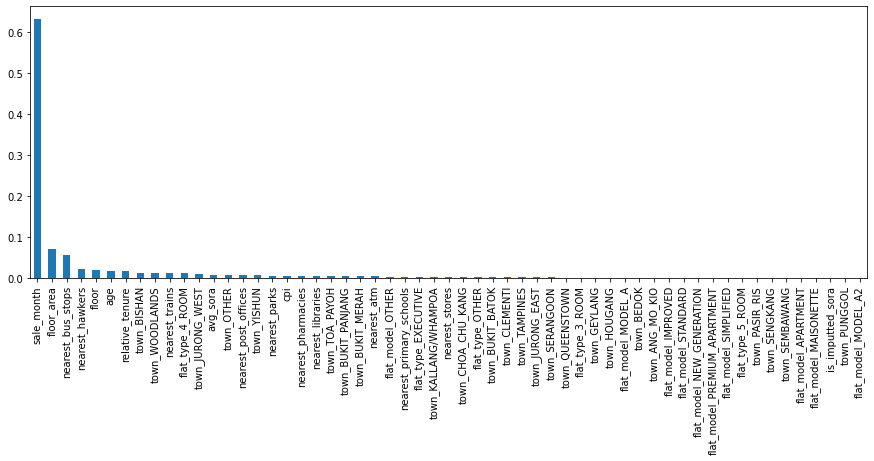

In [18]:
features_series = pd.Series(feature_impts.values(), index=feature_impts.keys())
features_series.sort_values(ascending=False,inplace=True)
plt.figure(figsize=(15,5))
features_series.plot(kind = 'bar')
plt.show()

# Actual vs Predicted

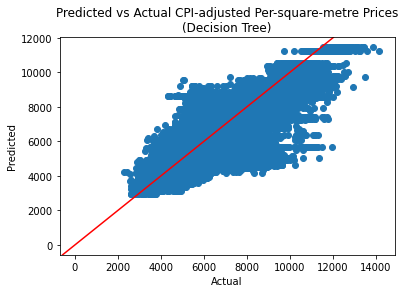

In [19]:
fig, ax = plt.subplots()
ax.axline((0, 0), slope=1, color="red")
plt.scatter(y_test, y_pred)
plt.title("Predicted vs Actual CPI-adjusted Per-square-metre Prices\n(Decision Tree)")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()